# Canopy Height Map in Dak Lak (Viet Nam) based on GEDI, Sentinel-1 and Sentinel-2 data with Convolutional Neural Network Unet Architecture

## 1. Data Preparation

In [2]:
PATCH_SIZE = 256
TILE_SIZE = 1024

In [3]:
import rasterio

# Path to the merged mosaic
mosaic_fp = "/root/Bản sao của Bản sao của Bản sao của DakLak_Full_Merged_Final_Final.tif"

# Open and read the data
with rasterio.open(mosaic_fp) as src:
    mosaic = src.read()  # This reads all bands as a NumPy array
    mosaic_meta = src.meta  # Save metadata if needed

print("Mosaic shape:", mosaic.shape)  # (bands, height, width)


Mosaic shape: (15, 13879, 16445)


In [4]:
import numpy as np
# Compute reasonable thresholds
low_q = np.nanpercentile(mosaic[0], 0.1)
high_q = np.nanpercentile(mosaic[0], 99.9)

print("Low threshold:", low_q)
print("High threshold:", high_q)

Low threshold: 1.8300000429153442
High threshold: 51.675399244795


In [5]:
band0 = mosaic[0].astype(float)
cleaned_band0 = np.where((band0 < low_q) | (band0 > high_q), np.nan, band0)
mosaic[0] = cleaned_band0

In [6]:
band_name = ['rh95', 'VV_ascending', 'VH_ascending', 'VV_descending', 'VH_descending', 
 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

In [26]:
import numpy as np

def tile_mosaic(mosaic, tile_size, check_band=1):
    """
    mosaic: numpy array (bands, height, width)
    tile_size: tile size in pixels (int)
    check_band: 0-based index of band to check for NaNs
    """
    bands, height, width = mosaic.shape
    tiles = []
    
    for i in range(0, height, tile_size):
        for j in range(0, width, tile_size):
            # Ensure we stay inside the image
            if i + tile_size > height or j + tile_size > width:
                continue
                
            tile = mosaic[:, i:i+tile_size, j:j+tile_size]
            # Check for NaNs in the specified band
            if not np.isnan(tile[check_band]).any():
                tiles.append(tile)
    
    return tiles

# Example usage
tiles = tile_mosaic(mosaic, TILE_SIZE, check_band=1)
print("Number of tiles without NaNs:", len(tiles))


Number of tiles without NaNs: 91


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split

# has_gedi = True if tile has any GEDI footprint (layer 0)
has_gedi = np.array([np.any(~np.isnan(tile[0])) for tile in tiles])

# Only keep tiles with GEDI for training
tiles_with_gedi = [tile for tile, gedi in zip(tiles, has_gedi) if gedi]

train_idx, temp_idx = train_test_split(
    np.arange(len(tiles_with_gedi)),
    test_size=0.2,   # temp is 20%
    random_state=42
)

# Second split: validation vs test (split temp 50/50 → 10% each)
validation_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    random_state=42
)
tiles_train = [tiles_with_gedi[i] for i in train_idx]
tiles_validation = [tiles_with_gedi[i] for i in validation_idx]
tiles_test = [tiles_with_gedi[i] for i in test_idx]

print("Total tiles with GEDI:", len(tiles_with_gedi))
print("Training tiles:", len(tiles_train))
print("Validation tiles:", len(tiles_validation))
print("Testing tiles:", len(tiles_test))


Total tiles with GEDI: 91
Training tiles: 72
Validation tiles: 9
Testing tiles: 10


In [53]:
tiles_train += tiles_validation

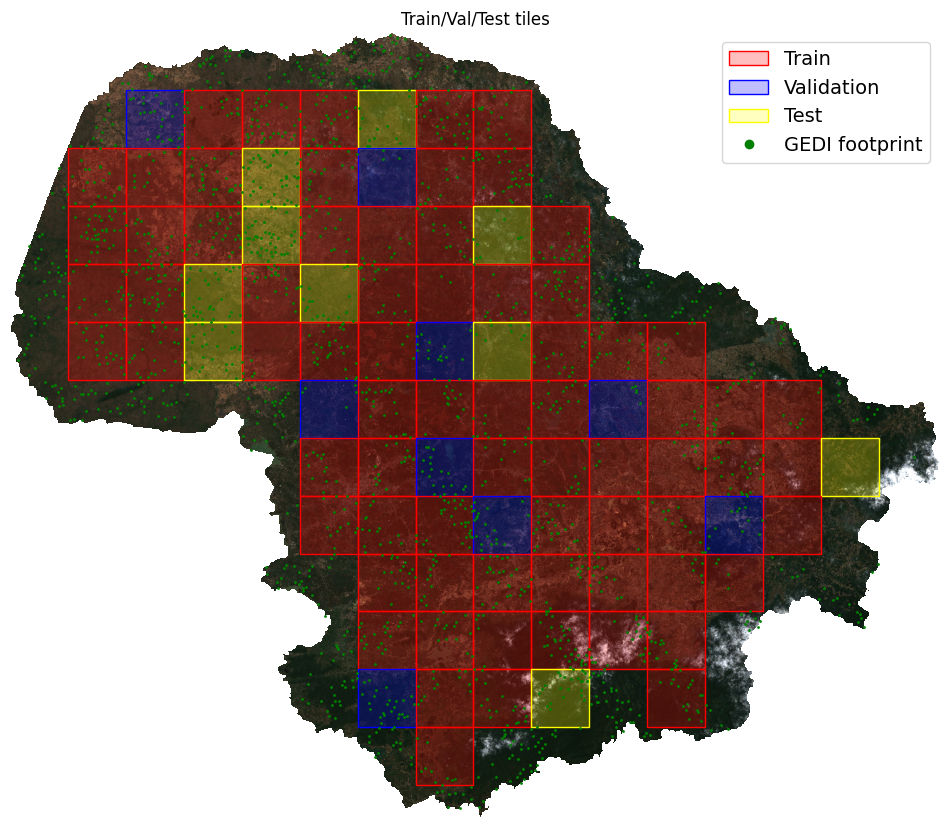

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

# -----------------------------------------
# COLORS (RGBA with opacity)
# -----------------------------------------
COLOR_TRAIN = (1, 0, 0, 0.25)      # red,   25% opacity
COLOR_VAL   = (0, 0, 1, 0.25)      # blue,  25% opacity
COLOR_TEST  = (1, 1, 0, 0.25)      # yellow,25% opacity

# -----------------------------------------
# BUILD TILE INDEX → SPLIT LOOKUP
# -----------------------------------------
tile_split = {}
for idx in train_idx:
    tile_split[idx] = 'train'
for idx in validation_idx:
    tile_split[idx] = 'val'
for idx in test_idx:
    tile_split[idx] = 'test'

# -----------------------------------------
# LOAD IMAGE (BGR → RGB)
# -----------------------------------------
# BGR channels at index 5,6,7
img_bgr = mosaic[5:8, :, :]                 # shape = (3, H, W), BGR
gedi = mosaic[0]
# Convert BGR → RGB
img_rgb = img_bgr[[2, 1, 0], :, :]          # reorder
img_rgb = np.transpose(img_rgb, (1, 2, 0))  # shape = (H, W, 3)

# -----------------------------------------
# DOWNSAMPLE IMAGE FOR PLOTTING
# -----------------------------------------
scale = 10
img_small = img_rgb[::scale, ::scale, :]
gedi_small = gedi[::scale, ::scale]

# -----------------------------------------
# START PLOTTING
# -----------------------------------------
plt.figure(figsize=(12, 12))
plt.imshow(img_small)
plt.title("Train/Val/Test tiles")
plt.axis("off")

# -----------------------------------------
# TILE DRAWING PARAMETERS
# -----------------------------------------
pixels_per_tile = TILE_SIZE
height, width, _ = img_rgb.shape   # correct shape

tile_count = 0

# -----------------------------------------
# DRAW TILES
# -----------------------------------------
for i in range(0, height, pixels_per_tile):
    for j in range(0, width, pixels_per_tile):

        tile = img_rgb[i:i+pixels_per_tile, j:j+pixels_per_tile, :]

        # Skip tiles with NaN
        if not np.isnan(tile).any():

            # Select color for this tile
            if tile_count in tile_split:
                split = tile_split[tile_count]
                if split == 'train':
                    face_color = COLOR_TRAIN
                    edge_color = 'red'
                elif split == 'val':
                    face_color = COLOR_VAL
                    edge_color = 'blue'
                elif split == 'test':
                    face_color = COLOR_TEST
                    edge_color = 'yellow'
            else:
                face_color = (1, 1, 1, 0)  # fully transparent
                edge_color = 'white'

            # Draw rectangle (scaled coordinates)
            rect = Rectangle(
                (j / scale, i / scale),
                pixels_per_tile / scale,
                pixels_per_tile / scale,
                linewidth=1,
                edgecolor=edge_color,
                facecolor=face_color
            )
            plt.gca().add_patch(rect)

            tile_count += 1

# -----------------------------------------
# LEGEND
# -----------------------------------------
legend_patches = [
    Patch(facecolor=COLOR_TRAIN, edgecolor='red', label='Train'),
    Patch(facecolor=COLOR_VAL,   edgecolor='blue', label='Validation'),
    Patch(facecolor=COLOR_TEST,  edgecolor='yellow', label='Test')
]

plt.legend(handles=legend_patches, loc='upper right', fontsize=14)

# -----------------------------------------
# GEDI Footprint
# -----------------------------------------
y, x = np.where(~np.isnan(gedi_small))
plt.scatter(x, y, s=1, color='green', label='GEDI footprint')
scatter_handle = plt.Line2D([], [], marker='o', linestyle='None',
                            markersize=6, color='green', label='GEDI footprint')

plt.legend(handles=legend_patches + [scatter_handle],
           loc='upper right', fontsize=14)

# -----------------------------------------
# SHOW PLOT
# -----------------------------------------
plt.show()


In [55]:
all_test_patches = []

for tile in tiles_test:
    C, H, W = tile.shape
    for i in range(0, H, PATCH_SIZE):
        for j in range(0, W, PATCH_SIZE):
            patch = tile[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            all_test_patches.append(patch)

print(f"Total test patches: {len(all_test_patches)}")
print(f"Example patch shape: {all_test_patches[0].shape}")

Total test patches: 160
Example patch shape: (15, 256, 256)


In [56]:
import numpy as np

# Suppose all_test_patches is a list of (15, 256, 256) arrays
all_nan_patches_idx = []

for idx, patch in enumerate(all_test_patches):
    # Check if layer 0 is all NaNs
    if np.all(np.isnan(patch[0])):
        all_nan_patches_idx.append(idx)

print(f"Patches with all NaNs in layer 0: {all_nan_patches_idx}")
print(f"Number of such patches: {len(all_nan_patches_idx)}")
all_test_patches = [patch for idx, patch in enumerate(all_test_patches)
                      if idx not in all_nan_patches_idx]


Patches with all NaNs in layer 0: [9, 10, 13, 14, 15, 57, 62, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 134, 135, 139, 145, 150]
Number of such patches: 28


In [57]:
all_validation_patches = []

for tile in tiles_validation:
    C, H, W = tile.shape
    for i in range(0, H, PATCH_SIZE):
        for j in range(0, W, PATCH_SIZE):
            patch = tile[:, i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            all_validation_patches.append(patch)

print(f"Total test patches: {len(all_validation_patches)}")
print(f"Example patch shape: {all_validation_patches[0].shape}")

Total test patches: 144
Example patch shape: (15, 256, 256)


In [58]:
import numpy as np

# Suppose all_test_patches is a list of (15, 256, 256) arrays
all_nan_patches_idx = []

for idx, patch in enumerate(all_validation_patches):
    # Check if layer 0 is all NaNs
    if np.all(np.isnan(patch[0])):
        all_nan_patches_idx.append(idx)

print(f"Patches with all NaNs in layer 0: {all_nan_patches_idx}")
print(f"Number of such patches: {len(all_nan_patches_idx)}")
all_validation_patches = [patch for idx, patch in enumerate(all_validation_patches)
                      if idx not in all_nan_patches_idx]


Patches with all NaNs in layer 0: [2, 17, 21, 22, 24, 25, 29, 31, 33, 37, 38, 41, 42, 43, 46, 47, 73, 77, 78, 81, 82, 86, 98, 108, 116, 120, 121, 122, 123, 124, 125, 126, 130]
Number of such patches: 33


In [59]:
import numpy as np

# Total non-NaN pixels in layer 0 for training tiles
total_train_gedi = sum(np.count_nonzero(~np.isnan(tile[0])) for tile in tiles_train)
total_validation_gedi = sum(np.count_nonzero(~np.isnan(tile[0])) for tile in all_validation_patches)
# Total non-NaN pixels in layer 0 for testing tiles
total_test_gedi = sum(np.count_nonzero(~np.isnan(tile[0])) for tile in all_test_patches)

print("Total non-NaN pixels in layer 0 (train):", total_train_gedi)
print("Total non-NaN pixels in layer 0 (validation):", total_validation_gedi)
print("Total non-NaN pixels in layer 0 (test):", total_test_gedi)


Total non-NaN pixels in layer 0 (train): 127821
Total non-NaN pixels in layer 0 (validation): 13403
Total non-NaN pixels in layer 0 (test): 19958


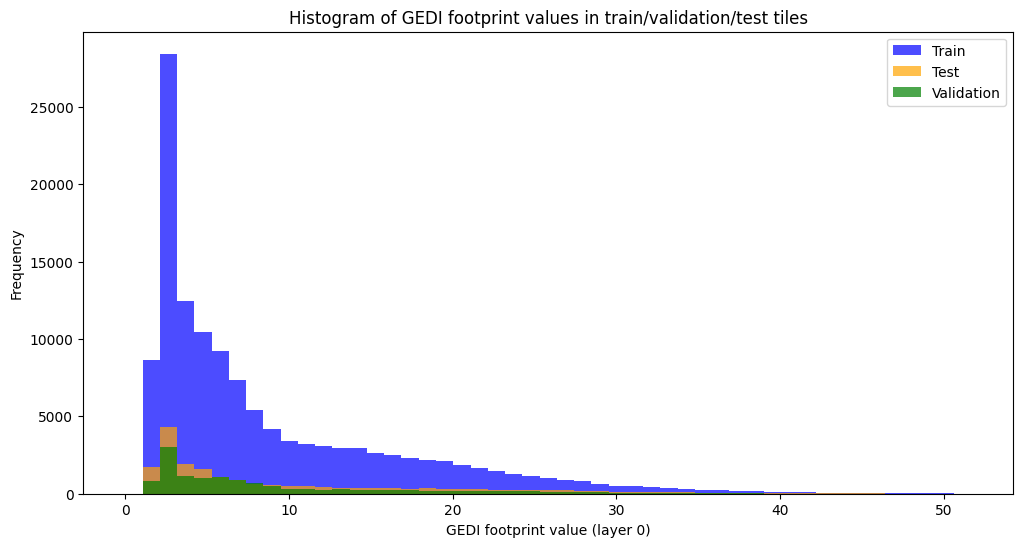

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Gather all non-NaN GEDI values from train tiles
train_values = np.concatenate([tile[0][~np.isnan(tile[0])] for tile in tiles_train])
validation_values = np.concatenate([tile[0][~np.isnan(tile[0])] for tile in tiles_validation])
# Gather all non-NaN GEDI values from test tiles
test_values = np.concatenate([tile[0][~np.isnan(tile[0])] for tile in tiles_test])

# Plot histogram with bins
bins = np.linspace(0, np.nanmax(mosaic[0]), 50)  # 50 bins from 0 to max height

plt.figure(figsize=(12,6))
plt.hist(train_values, bins=bins, alpha=0.7, label='Train', color='blue')
plt.hist(test_values, bins=bins, alpha=0.7, label='Test', color='orange')
plt.hist(validation_values, bins=bins, alpha=0.7, label='Validation', color='green')
plt.xlabel('GEDI footprint value (layer 0)')
plt.ylabel('Frequency')
plt.title('Histogram of GEDI footprint values in train/validation/test tiles')
plt.legend()
plt.show()


## 2. CNN Unet Architecture Model

In [61]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch version: {torch.__version__}")
print(f"Device: {device}")

Torch version: 2.8.0+cu129
Device: cuda


In [62]:
def double_convolution_down(in_channels, out_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op

def double_convolution_up(in_channels, hidden_channels, out_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return conv_op

def output_convolution(in_channels, hidden_channels, output_channels, p_dropout=0.2):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(hidden_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(hidden_channels, output_channels, kernel_size=1, padding=0)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoding path
        self.down_convolution_1 = double_convolution_down(num_channels, 64)
        self.down_convolution_2 = double_convolution_down(64, 128)
        self.down_convolution_3 = double_convolution_down(128, 256)
        self.down_convolution_4 = double_convolution_down(256, 512)
        self.down_convolution_5 = double_convolution_down(512, 512)
        # Decoding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=512,
            kernel_size=2, 
            stride=2)
        self.up_convolution_1 = double_convolution_up(1024, 512, 256)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=256,
            kernel_size=2, 
            stride=2)
        self.up_convolution_2 = double_convolution_up(512, 256, 128)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=128,
            kernel_size=2, 
            stride=2)
        self.up_convolution_3 = double_convolution_up(256, 128, 64)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=64, out_channels=64,
            kernel_size=2, 
            stride=2)
        self.up_convolution_4 = output_convolution(128, 64, num_classes)

    def forward(self, x):
        # Encoding
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)        
        # Decoding
        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        out = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        return out

In [63]:
import torch
import torch.nn as nn

class MaskedMAELoss(nn.Module):
    def forward(self, pred, target):
        # pred and target shapes: [B, 1, H, W]
        mask = ~torch.isnan(target)    
        loss = torch.abs(pred[mask] - target[mask])
        return loss.mean()


In [64]:
import torch

def global_masked_r2(all_preds, all_targets):
    """
    all_preds, all_targets: list of 1D tensors
    """
    y_pred = torch.cat(all_preds)   # shape: [N]
    y_true = torch.cat(all_targets) # shape: [N]

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    return 1 - ss_res / (ss_tot + 1e-8)


In [65]:
import torch
from torch.utils.data import Dataset
import numpy as np
import random

class TilePatchDataset(Dataset):
    def __init__(self, tiles, patch_size=256, patches_per_epoch=960):
        self.tiles = tiles
        self.patch_size = patch_size
        self.patches_per_epoch = patches_per_epoch

        # Compute weights proportional to GEDI footprints
        self.weights = np.array([np.sum(~np.isnan(tile[0])) for tile in tiles], dtype=np.float32)
        if self.weights.sum() > 0:
            self.weights /= self.weights.sum()
        else:
            self.weights = np.ones(len(tiles)) / len(tiles)

    def __len__(self):
        return self.patches_per_epoch  # exactly this many patches per epoch

    def __getitem__(self, idx):
        # Weighted random tile selection
        tile_idx = np.random.choice(len(self.tiles), p=self.weights)
        tile = self.tiles[tile_idx]

        C, H, W = tile.shape
        ph = pw = self.patch_size

        # Random patch with at least one GEDI footprint
        for _ in range(50):
            x = random.randint(0, W - pw)
            y = random.randint(0, H - ph)
            gedi_patch = tile[0, y:y+ph, x:x+pw]
            if np.any(~np.isnan(gedi_patch)):
                img_patch = tile[1:, y:y+ph, x:x+pw]  # input features
                break
        else:
            x = (W - pw)//2
            y = (H - ph)//2
            img_patch = tile[1:, y:y+ph, x:x+pw]
            gedi_patch = tile[0, y:y+ph, x:x+pw]

        img_patch = torch.tensor(img_patch, dtype=torch.float32)
        gedi_patch = torch.tensor(gedi_patch, dtype=torch.float32).unsqueeze(0)

        return img_patch, gedi_patch


In [66]:
class TileFullDataset(Dataset):
    def __init__(self, tiles):
        """
        tiles: list of numpy arrays [C,H,W]
               layer 0 = GEDI (label)
               layer 1.. = input features
        """
        self.tiles = tiles

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        tile = self.tiles[idx]

        img = tile[1:]                         # inputs
        gedi = tile[0:1]                       # label (keep channel dim)

        img = torch.tensor(img, dtype=torch.float32)
        gedi = torch.tensor(gedi, dtype=torch.float32)

        return img, gedi


In [67]:
from torch.utils.data import DataLoader

patch_size = PATCH_SIZE
batch_size = 32

train_dataset = TilePatchDataset(tiles_train, patch_size=patch_size)
validation_dataset = TileFullDataset(all_validation_patches)
test_dataset  = TileFullDataset(all_test_patches)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [68]:
import torch.optim as optim

model = UNet(num_channels=14, num_classes=1).to(device)
model = nn.DataParallel(model).to(device)
criterion = MaskedMAELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
# 'triangular2' scheduler from torch.optim.lr_scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=320,  # half cycle
    mode='triangular2'
)

num_epochs = 200
train_mae = []
validation_mae = []
validation_rmse = []
validation_r2 = []
for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0

    for imgs, gedi in train_loader:
        imgs = imgs.to(device)
        gedi = gedi.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, gedi)
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # --- Testing / Validation ---
    model.eval()
    all_preds = []
    all_targets = []
    running_r2 = 0.0
    test_loss = 0.0
    with torch.inference_mode():
        for imgs, gedi in test_loader:
            imgs = imgs.to(device)
            gedi = gedi.to(device)

            preds = model(imgs)
            loss = criterion(preds, gedi)

            mask = ~torch.isnan(gedi)
            y_true = gedi[mask].detach().cpu()
            y_pred = preds[mask].detach().cpu()
            all_targets.append(y_true)
            all_preds.append(y_pred)

            test_loss += loss.item()

    global_r2 = global_masked_r2(all_preds, all_targets)
    test_loss /= len(test_loader)

    y_pred_all = torch.cat(all_preds)
    y_true_all = torch.cat(all_targets)

    mse = torch.mean((y_pred_all - y_true_all) ** 2)
    rmse = torch.sqrt(mse).item()
    train_mae.append(train_loss)
    validation_mae.append(test_loss)
    validation_rmse.append(rmse)
    validation_r2.append(global_r2)
    print(f"Epoch {epoch+1}/{num_epochs} | Train MAE: {train_loss:.4f} | Test MAE: {test_loss:.4f} | Test RMSE: {rmse:.4f} | Test R2: {global_r2:.4f}")



Epoch 1/200 | Train MAE: 9.4098 | Test MAE: 9.0185 | Test RMSE: 13.4195 | Test R2: -0.9560
Epoch 2/200 | Train MAE: 8.4526 | Test MAE: 7.8659 | Test RMSE: 12.5591 | Test R2: -0.7132
Epoch 3/200 | Train MAE: 7.9280 | Test MAE: 7.5939 | Test RMSE: 12.8917 | Test R2: -0.8051
Epoch 4/200 | Train MAE: 7.8399 | Test MAE: 7.7751 | Test RMSE: 12.8163 | Test R2: -0.7841
Epoch 5/200 | Train MAE: 7.1899 | Test MAE: 8.4081 | Test RMSE: 13.0196 | Test R2: -0.8411
Epoch 6/200 | Train MAE: 6.6015 | Test MAE: 6.8342 | Test RMSE: 11.6218 | Test R2: -0.4670
Epoch 7/200 | Train MAE: 6.6902 | Test MAE: 6.0303 | Test RMSE: 10.3099 | Test R2: -0.1545
Epoch 8/200 | Train MAE: 5.9334 | Test MAE: 6.8111 | Test RMSE: 11.1097 | Test R2: -0.3406
Epoch 9/200 | Train MAE: 5.5468 | Test MAE: 7.5150 | Test RMSE: 11.6789 | Test R2: -0.4815
Epoch 10/200 | Train MAE: 5.0736 | Test MAE: 5.7158 | Test RMSE: 7.1818 | Test R2: 0.4398
Epoch 11/200 | Train MAE: 4.8704 | Test MAE: 5.0425 | Test RMSE: 7.0886 | Test R2: 0.4542
E

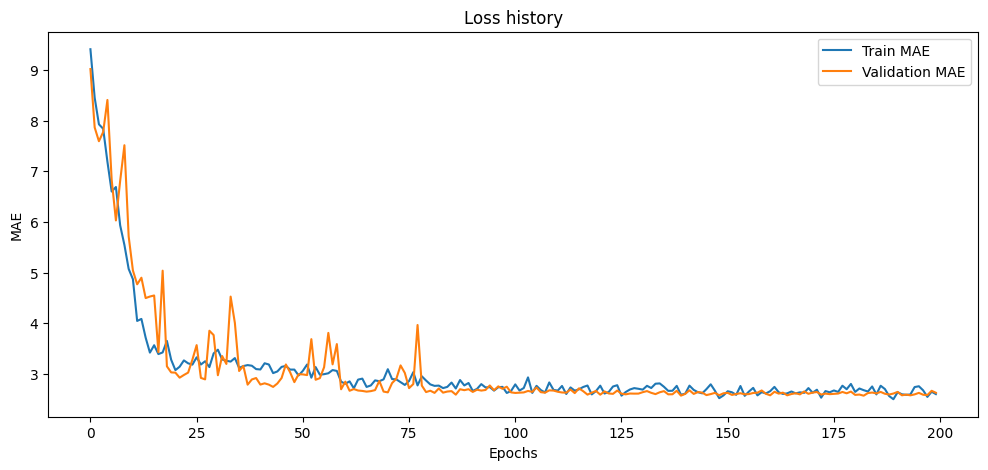

In [69]:
import matplotlib.pyplot as plt
# Vẽ MAE
epochs = range(0, 200, 1)
plt.figure(figsize=(12,5))
plt.plot(epochs, train_mae, label='Train MAE')
plt.plot(epochs, validation_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Loss history')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
running_r2 = 0.0
test_loss = 0.0
model.eval()
with torch.inference_mode():
    for imgs, gedi in test_loader:
        imgs = imgs.to(device)
        gedi = gedi.to(device)

        preds = model(imgs)
        loss = criterion(preds, gedi)

        mask = ~torch.isnan(gedi)
        y_true = gedi[mask].detach().cpu()
        y_pred = preds[mask].detach().cpu()
        all_targets.append(y_true)
        all_preds.append(y_pred)

        test_loss += loss.item()

global_r2 = global_masked_r2(all_preds, all_targets)
test_loss /= len(test_loader)

y_pred_all = torch.cat(all_preds)
y_true_all = torch.cat(all_targets)

mse = torch.mean((y_pred_all - y_true_all) ** 2)
rmse = torch.sqrt(mse).item()
print(f"Test MAE: {test_loss:.4f} | Test RMSE: {rmse:.4f} | Test R2: {global_r2:.4f}")

Test MAE: 2.6293 | Test RMSE: 4.1612 | Test R2: 0.8119
